In [164]:
import numpy as np 

import pandas as pd 

import matplotlib.pyplot as plt

import json 

import requests 

from geopy.geocoders import Nominatim 

from sklearn.cluster import KMeans

import folium 

from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries successfully imported.')

Libraries imported.


#### In this capstone project, I will be exploring neighborhoods in Central Los Angeles in Los Angeles County. According to https://en.wikipedia.org/wiki/Central_Los_Angeles, there are 26 neighborhoods in Central Los Angeles. To get the names of those neighborhoods, we will send an http request.

In [552]:
url = 'https://en.wikipedia.org/wiki/Central_Los_Angeles'
r = requests.get(url).text

#### The BeautifulSoup package will help us to scrape the names of the neighborhoods from the website.

In [553]:
soup = BeautifulSoup(r, features = "html.parser" )

In [554]:
list_neighborhoods = []
neighborhoods_table = soup.find_all('div', class_ = 'div-col columns column-width')[5].ul
for hood in neighborhoods_table.find_all('li'):
    neighborhood = hood.a.string
    list_neighborhoods.append(neighborhood)
    
print(len(list_neighborhoods))
list_neighborhoods

26


['Arlington Heights',
 'Beverly Grove',
 'Carthay',
 'Chinatown',
 'Downtown',
 'East Hollywood',
 'Echo Park',
 'Elysian Park',
 'Elysian Valley',
 'Faircrest Heights',
 'Griffith Park',
 'Hancock Park',
 'Harvard Heights',
 'Hollywood',
 'Hollywood Hills',
 'Hollywood Hills West',
 'Koreatown',
 'Larchmont',
 'Los Feliz',
 'Mid-City',
 'Mid-Wilshire',
 'Pico-Union',
 'Silver Lake',
 'West Hollywood',
 'Westlake',
 'Windsor Square']

#### According to http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_LA_Neighborhoods_Data Faircrest Heights neighborhood is called as Fairfax. Therefore, we will change the name accordingly.

In [555]:
list_neighborhoods.index('Faircrest Heights')
list_neighborhoods[9] = 'Fairfax'

#### I googled and found the following data for Los Angeles City. Here is the link http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_LA_Neighborhoods_Data

In [614]:
url2 = "http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_LA_Neighborhoods_Data"
all_data = pd.read_html(url2)[2]
all_data.head()

,LA_Nbhd,Income,Schools,Diversity,Age,Homes,Vets,Asian,Black,Latino,White,Population,Area,Longitude,Latitude
0,Adams_Normandie,29606,691,0.6,26,0.26,0.05,0.05,0.25,0.62,0.06,31068,0.8,-118.300270,34.030970
1,Arleta,65649,719,0.4,29,0.29,0.07,0.11,0.02,0.72,0.13,31068,3.1,-118.430015,34.240603
2,Arlington_Heights,31423,687,0.8,31,0.31,0.05,0.13,0.25,0.57,0.05,22106,1.0,-118.320109,34.043611
3,Atwater_Village,53872,762,0.9,34,0.34,0.06,0.20,0.01,0.51,0.22,14888,1.8,-118.265808,34.124908
4,Baldwin_Hills/Crenshaw,37948,656,0.4,36,0.36,0.10,0.05,0.71,0.17,0.03,30123,3.0,-118.366700,34.019090


#### Let's drop the columns that we do not need

In [556]:
all_data.rename(columns = {'LA_Nbhd': 'Neighborhood'}, inplace = True)
all_data = all_data.drop(labels = ['Schools', 'Diversity', 'Age', 'Homes', 'Vets', 'Asian', 'Black', 'Latino',
                                   'White', 'Population', 'Area', 'Income'], axis = 1)
all_data

,Neighborhood,Longitude,Latitude
0,Adams_Normandie,-118.300270,34.030970
1,Arleta,-118.430015,34.240603
2,Arlington_Heights,-118.320109,34.043611
3,Atwater_Village,-118.265808,34.124908
4,Baldwin_Hills/Crenshaw,-118.366700,34.019090
5,Bel-Air,-118.463558,34.096148
6,Beverly_Crest,-118.424713,34.112107
7,Beverly_Grove,-118.372111,34.076009
8,Beverlywood,-118.395011,34.041610
9,Boyle_Heights,-118.205370,34.033700


#### Here, the names of neighborhoods in list_neighborhoods are modified to match for those in all_data

In [557]:
for index, hood in enumerate(list_neighborhoods):
    one = hood.replace(' ', '_') 
    two = one.replace('-','_')
    list_neighborhoods[index] = two
list_neighborhoods

['Arlington_Heights',
 'Beverly_Grove',
 'Carthay',
 'Chinatown',
 'Downtown',
 'East_Hollywood',
 'Echo_Park',
 'Elysian_Park',
 'Elysian_Valley',
 'Fairfax',
 'Griffith_Park',
 'Hancock_Park',
 'Harvard_Heights',
 'Hollywood',
 'Hollywood_Hills',
 'Hollywood_Hills_West',
 'Koreatown',
 'Larchmont',
 'Los_Feliz',
 'Mid_City',
 'Mid_Wilshire',
 'Pico_Union',
 'Silver_Lake',
 'West_Hollywood',
 'Westlake',
 'Windsor_Square']

#### However, the table above contains data for the entire LA city neighborhoods. Because we are going to explore only the Central LA area, we need to remove all other neighborhoods that are outside the Central LA area. 

In [558]:
central_la_data = all_data[all_data['Neighborhood'].isin(list_neighborhoods)].reset_index(drop=True)
print(central_la_data.shape)
central_la_data.head()

(24, 3)


,Neighborhood,Longitude,Latitude
0,Arlington_Heights,-118.320109,34.043611
1,Beverly_Grove,-118.372111,34.076009
2,Carthay,-118.369000,34.059000
3,Chinatown,-118.235806,34.063711
4,Downtown,-118.246707,34.040812


#### As we can see from the shape attribute, we have got only 24 neighborhoods. Thus, for those two missing neighborhoods, we will manually enter the latitude and longitude values found in https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr link. Note that Griffith Park has 0 income. This is because it is a large park area with relatively few houses.

In [559]:
missing_hood = pd.DataFrame({'Neighborhood': ['Griffith_Park', 'West_Hollywood'], 
                             'Longitude': [-118.297156, -118.369613], 'Latitude': [34.136874, 34.087213]})

In [560]:
central_la_data = pd.concat([central_la_data, missing_hood], ignore_index = True )
central_la_data

,Neighborhood,Longitude,Latitude
0,Arlington_Heights,-118.320109,34.043611
1,Beverly_Grove,-118.372111,34.076009
2,Carthay,-118.369000,34.059000
3,Chinatown,-118.235806,34.063711
4,Downtown,-118.246707,34.040812
5,East_Hollywood,-118.295108,34.089509
6,Echo_Park,-118.258707,34.079010
7,Elysian_Park,-118.249807,34.082510
8,Elysian_Valley,-118.241107,34.095009
9,Fairfax,-118.353310,34.078209


#### I have found the Average Rent price for Los Angeles neighborhoods. Here is the link https://www.rentcafe.com/average-rent-market-trends/us/ca/los-angeles/. I have scraped the web page and read the data into the following dataframe. 

In [561]:
column_names = ['Neighborhood', 'Average Rent']

rent_data = pd.DataFrame(columns = column_names )
rent_data

,Neighborhood,Average Rent


In [562]:
url3 = "https://www.rentcafe.com/average-rent-market-trends/us/ca/los-angeles/"
r3 = requests.get(url3).text
soup3 = BeautifulSoup(r3, features = "html.parser" )

In [563]:
table = soup3.find('table', id = 'MarketTrendsAverageRentTable').tbody
rows = table.find_all('tr')[1:]
for row in rows:
    neighborhood = row.th.string
    avg_rent = row.td.string
    rent_data = rent_data.append({'Neighborhood': neighborhood,
                                        'Average Rent': avg_rent}, ignore_index = True)
rent_data.head()

,Neighborhood,Average Rent
0,Jefferson Park,"$1,355"
1,El Sereno,"$1,396"
2,Vermont Vista,"$1,445"
3,Vermont Knolls,"$1,445"
4,Hyde Park,"$1,484"


In [564]:
rent_data['Neighborhood'] = rent_data['Neighborhood'].apply(lambda x: x.replace(' ', '_'))
rent_data['Neighborhood'] = rent_data['Neighborhood'].apply(lambda x: x.replace('-', '_'))
rent_data

,Neighborhood,Average Rent
0,Jefferson_Park,"$1,355"
1,El_Sereno,"$1,396"
2,Vermont_Vista,"$1,445"
3,Vermont_Knolls,"$1,445"
4,Hyde_Park,"$1,484"
5,Glassell_Park,"$1,485"
6,Cypress_Park,"$1,485"
7,Winnetka,"$1,526"
8,Sunland,"$1,571"
9,Leimert_Park,"$1,575"


In [566]:
central_la_data = central_la_data.merge(rent_data, how = 'left', on = 'Neighborhood')
central_la_data

,Neighborhood,Longitude,Latitude,Average Rent
0,Arlington_Heights,-118.320109,34.043611,"$1,605"
1,Beverly_Grove,-118.372111,34.076009,"$3,804"
2,Carthay,-118.369000,34.059000,"$3,591"
3,Chinatown,-118.235806,34.063711,"$2,530"
4,Downtown,-118.246707,34.040812,NaN
5,East_Hollywood,-118.295108,34.089509,"$2,077"
6,Echo_Park,-118.258707,34.079010,"$2,301"
7,Elysian_Park,-118.249807,34.082510,"$2,501"
8,Elysian_Valley,-118.241107,34.095009,"$2,088"
9,Fairfax,-118.353310,34.078209,"$2,927"


##### As we can see three rows for average rent generated as NaN. We do have those values on the  web page. I will manually enter them to eliminate this issue.

In [569]:
central_la_data.loc[4, 'Average Rent'] = '$2,649'
central_la_data.loc[20, 'Average Rent'] = '$2,904'
central_la_data.loc[25, 'Average Rent'] = '$2,732'
central_la_data

,Neighborhood,Longitude,Latitude,Average Rent
0,Arlington_Heights,-118.320109,34.043611,"$1,605"
1,Beverly_Grove,-118.372111,34.076009,"$3,804"
2,Carthay,-118.369000,34.059000,"$3,591"
3,Chinatown,-118.235806,34.063711,"$2,530"
4,Downtown,-118.246707,34.040812,"$2,649"
5,East_Hollywood,-118.295108,34.089509,"$2,077"
6,Echo_Park,-118.258707,34.079010,"$2,301"
7,Elysian_Park,-118.249807,34.082510,"$2,501"
8,Elysian_Valley,-118.241107,34.095009,"$2,088"
9,Fairfax,-118.353310,34.078209,"$2,927"


#### Let's first find latitude and longitude values of Los Angeles City, CA.

In [570]:
address = 'Los Angeles City, CA'

geolocator = Nominatim(user_agent="my_fayettevill")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Fayetteville are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Fayetteville are 34.0536909, -118.2427666.


#### Let's create a map of Los Angeles City with the neighborhoods in it. 

In [571]:
map_la = folium.Map(location = (latitude, longitude), zoom_start = 12 )

for lat, lng, neighborhood in zip(central_la_data['Latitude'], central_la_data['Longitude'], 
                                           central_la_data['Neighborhood']):
    folium.CircleMarker(
                        [lat,lng],
                        popup = f'{neighborhood}',
                        fill = True,
                        radius = 5,
                        fill_opacity = 0.6,).add_to(map_la)
map_la

#### My Foursquare  credentials

In [572]:
CLIENT_ID = 'RCFAXHEZTIFU3TK0EZITACTPQWOQUIBDWA4DZEW3VYFW0WCK' # Foursquare ID
CLIENT_SECRET = 'O4VA0YCKW0JLS2M1JKKGEH42ZKTPWWZUOVKFWXPOXCCRNI1X' # Foursquare Secret
VERSION = '20200612' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: RCFAXHEZTIFU3TK0EZITACTPQWOQUIBDWA4DZEW3VYFW0WCK
CLIENT_SECRET:O4VA0YCKW0JLS2M1JKKGEH42ZKTPWWZUOVKFWXPOXCCRNI1X


#### Let's get the top 100 venues around each neighborhood within a radius of 500meters using Foursquare API

In [573]:
LIMIT = 100

In [574]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [576]:
central_la_venues = getNearbyVenues(names=central_la_data['Neighborhood'],
                                   latitudes=central_la_data['Latitude'],
                                   longitudes=central_la_data['Longitude'])

Arlington_Heights
Beverly_Grove
Carthay
Chinatown
Downtown
East_Hollywood
Echo_Park
Elysian_Park
Elysian_Valley
Fairfax
Hancock_Park
Harvard_Heights
Hollywood
Hollywood_Hills
Hollywood_Hills_West
Koreatown
Larchmont
Los_Feliz
Mid_City
Mid_Wilshire
Pico_Union
Silver_Lake
Westlake
Windsor_Square
Griffith_Park
West_Hollywood


In [577]:
print(central_la_venues.shape)
central_la_venues.head()

(707, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arlington_Heights,34.043611,-118.320109,Cafe Dabang,34.047407,-118.319082,Café
1,Arlington_Heights,34.043611,-118.320109,Natraliart Jamaican Restaurant,34.039750,-118.322392,Restaurant
2,Arlington_Heights,34.043611,-118.320109,Enterprise Rent-A-Car,34.046795,-118.318267,Rental Car Location
3,Arlington_Heights,34.043611,-118.320109,Liquor (Store),34.043711,-118.321467,Liquor Store
4,Arlington_Heights,34.043611,-118.320109,Louisiana Pico Seafood,34.047537,-118.320080,Seafood Restaurant


In [578]:
central_la_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arlington_Heights,8,8,8,8,8,8
Beverly_Grove,100,100,100,100,100,100
Carthay,15,15,15,15,15,15
Chinatown,44,44,44,44,44,44
Downtown,11,11,11,11,11,11
East_Hollywood,26,26,26,26,26,26
Echo_Park,41,41,41,41,41,41
Elysian_Park,13,13,13,13,13,13
Elysian_Valley,8,8,8,8,8,8


#### Number of unique categories

In [579]:
print(len(central_la_venues['Venue Category'].unique()))
central_la_venues['Venue Category'].unique()[:20]

183


array(['Café', 'Restaurant', 'Rental Car Location', 'Liquor Store',
       'Seafood Restaurant', 'Pizza Place', 'Shop & Service',
       'Grocery Store', 'Coffee Shop', 'Vegetarian / Vegan Restaurant',
       'Breakfast Spot', 'Asian Restaurant', 'Sandwich Place',
       'Juice Bar', 'Furniture / Home Store', 'Dim Sum Restaurant',
       'Hotel', 'Bakery', 'Mexican Restaurant', 'Gym / Fitness Center'],
      dtype=object)

#### Let's turn Venue Category into categorical variable

In [580]:
venue_categories = pd.get_dummies(central_la_venues['Venue Category'])
venue_categories['Neighborhood_name'] = central_la_venues['Neighborhood']
columns = [venue_categories.columns[-1]] + list(venue_categories.columns[:-1])
venue_categories = venue_categories[columns]
print(venue_categories.shape)
venue_categories.head()

(707, 184)


,Neighborhood_name,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Garden,Big Box Store,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cultural Center,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Movie Theater,Multiplex,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Noodle House,Paper / Office Supplies Store,Park,Pet Service,Pet Store,Pharmacy,Photography Lab,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Arlington_Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arlington_Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arlington_Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arlington_Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [581]:
central_la_grouped = venue_categories.groupby('Neighborhood_name').mean().reset_index()
central_la_grouped

,Neighborhood_name,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Garden,Big Box Store,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cultural Center,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Movie Theater,Multiplex,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Noodle House,Paper / Office Supplies Store,Park,Pet Service,Pet Store,Pharmacy,Photography Lab,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Arlington_Heights,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.125000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.125000,0.000000,0.000000,0.00,0.125,0.000000,0.00,0.000000,0.000000,0.00,0

#### The followinf function sorts the venues in descending order

In [582]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [583]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = central_la_grouped['Neighborhood_name']

for ind in np.arange(central_la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(central_la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington_Heights,Restaurant,Seafood Restaurant,Café,Grocery Store,Shop & Service,Pizza Place,Liquor Store,Rental Car Location,Dumpling Restaurant,Fast Food Restaurant
1,Beverly_Grove,Clothing Store,Cosmetics Shop,Juice Bar,Mexican Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Lingerie Store,Café,Gym / Fitness Center
2,Carthay,Ethiopian Restaurant,Historic Site,Fast Food Restaurant,Intersection,Dentist's Office,Video Store,Café,Park,Food Truck,Convenience Store
3,Chinatown,Chinese Restaurant,Vietnamese Restaurant,Bakery,Bar,Café,Coffee Shop,French Restaurant,Bookstore,Grocery Store,Brewery
4,Downtown,Arts & Crafts Store,Southern / Soul Food Restaurant,American Restaurant,Wine Bar,Gay Bar,Neighborhood,Café,Breakfast Spot,Sushi Restaurant,Flower Shop
5,East_Hollywood,Asian Restaurant,Pizza Place,Bakery,Restaurant,Pharmacy,Convenience Store,Fast Food Restaurant,Bus Line,Middle Eastern Restaurant,Coffee Shop
6,Echo_Park,Food Truck,Café,Mexican Restaurant,Bar,Pizza Place,Coffee Shop,American Restaurant,Art Museum,Restaurant,Wine Bar
7,Elysian_Park,Yoga Studio,Grocery Store,Furniture / Home Store,Juice Bar,Arts & Crafts Store,Café,Trail,Gift Shop,Scenic Lookout,Playground
8,Elysian_Valley,Trail,Rock Club,Gym / Fitness Center,Rental Car Location,Burrito Place,Spiritual Center,Intersection,Asian Restaurant,Fast Food Restaurant,Garden Center
9,Fairfax,Italian Restaurant,Mexican Restaurant,Pet Store,Arts & Crafts Store,Coffee Shop,Residential Building (Apartment / Condo),Mediterranean Restaurant,Dessert Shop,Sandwich Place,Cosmetics Shop


#### Now, we can cluster the neighborhoods. To do this, we will use elbow method which is very helpful to determine the appropriate number of clusters for the given data set.

In [584]:
central_la_grouped_clustering = central_la_grouped.drop('Neighborhood_name', 1)

ss_distances = []

n_clusters = range(1,10)

for i in n_clusters:
    kmeans = KMeans(n_clusters=i).fit(central_la_grouped_clustering)
    ss_distance = kmeans.inertia_
    ss_distances.append(ss_distance)

#### Let's plot the obtained result to make the decision about the number of clusters to work. 

Text(0, 0.5, 'Sum of square distance')

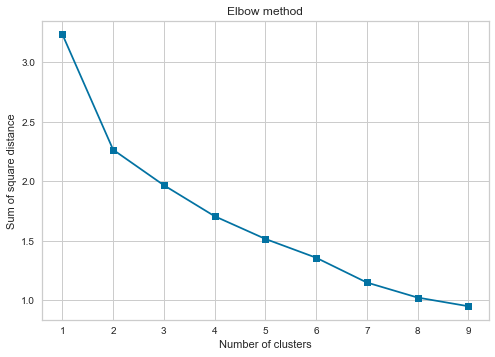

In [585]:
fig, ax = plt.subplots()
ax.plot(n_clusters, ss_distances, 's-' )
ax.set_title('Elbow method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Sum of square distance')

#### As we can see from the above plot sum of square distance does not decrease significantly after k=3. Therefore, we decide to use three clusters.

In [586]:
kmeans = KMeans(n_clusters=3).fit(central_la_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [587]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

central_la_data__merged = central_la_data

# merge neighborhoods_venues_sorted with central_la_data to add other features for each neighborhood
central_la_data__merged = central_la_data__merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# drop Windsor_Square because no values were returned from Forsquare API
central_la_data__merged.drop(labels = 23, inplace = True)
central_la_data__merged['Cluster Labels'] = central_la_data__merged['Cluster Labels'].astype('int32')

central_la_data__merged

,Neighborhood,Longitude,Latitude,Average Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington_Heights,-118.320109,34.043611,"$1,605",0,Restaurant,Seafood Restaurant,Café,Grocery Store,Shop & Service,Pizza Place,Liquor Store,Rental Car Location,Dumpling Restaurant,Fast Food Restaurant
1,Beverly_Grove,-118.372111,34.076009,"$3,804",0,Clothing Store,Cosmetics Shop,Juice Bar,Mexican Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Lingerie Store,Café,Gym / Fitness Center
2,Carthay,-118.369000,34.059000,"$3,591",0,Ethiopian Restaurant,Historic Site,Fast Food Restaurant,Intersection,Dentist's Office,Video Store,Café,Park,Food Truck,Convenience Store
3,Chinatown,-118.235806,34.063711,"$2,530",0,Chinese Restaurant,Vietnamese Restaurant,Bakery,Bar,Café,Coffee Shop,French Restaurant,Bookstore,Grocery Store,Brewery
4,Downtown,-118.246707,34.040812,"$2,649",0,Arts & Crafts Store,Southern / Soul Food Restaurant,American Restaurant,Wine Bar,Gay Bar,Neighborhood,Café,Breakfast Spot,Sushi Restaurant,Flower Shop
5,East_Hollywood,-118.295108,34.089509,"$2,077",0,Asian Restaurant,Pizza Place,Bakery,Restaurant,Pharmacy,Convenience Store,Fast Food Restaurant,Bus Line,Middle Eastern Restaurant,Coffee Shop
6,Echo_Park,-118.258707,34.079010,"$2,301",0,Food Truck,Café,Mexican Restaurant,Bar,Pizza Place,Coffee Shop,American Restaurant,Art Museum,Restaurant,Wine Bar
7,Elysian_Park,-118.249807,34.082510,"$2,501",0,Yoga Studio,Grocery Store,Furniture / Home Store,Juice Bar,Arts & Crafts Store,Café,Trail,Gift Shop,Scenic Lookout,Playground
8,Elysian_Valley,-118.241107,34.095009,"$2,088",1,Trail,Rock Club,Gym / Fitness Center,Rental Car Location,Burrito Place,Spiritual Center,Intersection,Asian Restaurant,Fast Food Restaurant,Garden Center
9,Fairfax,-118.353310,34.078209,"$2,927",0,Italian Restaurant,Mexican Restaurant,Pet Store,Arts & Crafts Store,Coffee Shop,Residential Building (Apartment / Condo),Mediterranean Restaurant,Dessert Shop,Sandwich Place,Cosmetics Shop


### Finally, let's visualize the choropleth map based on average rent price along with resulting clusters superimposed on top.

Here is the geojson file to define bounderies of the neighborhoods.

In [588]:
la_geo = 'C:/Users/jkhat/Desktop/Central_LA_Neighborhood.json'

In [600]:
central_la_data['Neighborhood'] = central_la_data['Neighborhood'].apply(lambda x: x.replace('_',' '))
central_la_data['Average Rent'] = central_la_data['Average Rent'].apply(lambda x: x.replace('$',''))
central_la_data['Average Rent'] = central_la_data['Average Rent'].apply(lambda x: x.replace(',',''))
central_la_data['Average Rent'] = central_la_data['Average Rent'].astype('int32')
central_la_data

,Neighborhood,Longitude,Latitude,Average Rent
0,Arlington Heights,-118.320109,34.043611,1605
1,Beverly Grove,-118.372111,34.076009,3804
2,Carthay,-118.369000,34.059000,3591
3,Chinatown,-118.235806,34.063711,2530
4,Downtown,-118.246707,34.040812,2649
5,East Hollywood,-118.295108,34.089509,2077
6,Echo Park,-118.258707,34.079010,2301
7,Elysian Park,-118.249807,34.082510,2501
8,Elysian Valley,-118.241107,34.095009,2088
9,Fairfax,-118.353310,34.078209,2927


#### Let's first generate choropleth map.

In [601]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
map_clusters.choropleth(
    geo_data=la_geo,
    data=central_la_data,
    columns=['Neighborhood', 'Average Rent'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
#     legend_name='Immigration to Canada'
)

# display map
map_clusters

C:\Users\jkhat\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


#### Now, the neighborhood clusters can be superimposed on top of the choropleth map.

In [613]:
# set color for the clusters
color = ['red', 'blue', 'green']


for lat, lon, poi, cluster, rent in zip(central_la_data__merged['Latitude'], central_la_data__merged['Longitude'],
                                  central_la_data__merged['Neighborhood'], central_la_data__merged['Cluster Labels'],
                                  central_la_data__merged['Average Rent']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+'    '+'rent=' + str(rent), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color[cluster], 
        fill=True,
        fill_color=color[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Let's Examine Clusters

### Cluster 1,  as we can see this cluster contains neighborhoods that has mostly restaurants 

In [604]:
central_la_data__merged.loc[central_la_data__merged['Cluster Labels'] == 0, central_la_data__merged.columns[[0] + list(range(5, central_la_data__merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington_Heights,Restaurant,Seafood Restaurant,Café,Grocery Store,Shop & Service,Pizza Place,Liquor Store,Rental Car Location,Dumpling Restaurant,Fast Food Restaurant
1,Beverly_Grove,Clothing Store,Cosmetics Shop,Juice Bar,Mexican Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Lingerie Store,Café,Gym / Fitness Center
2,Carthay,Ethiopian Restaurant,Historic Site,Fast Food Restaurant,Intersection,Dentist's Office,Video Store,Café,Park,Food Truck,Convenience Store
3,Chinatown,Chinese Restaurant,Vietnamese Restaurant,Bakery,Bar,Café,Coffee Shop,French Restaurant,Bookstore,Grocery Store,Brewery
4,Downtown,Arts & Crafts Store,Southern / Soul Food Restaurant,American Restaurant,Wine Bar,Gay Bar,Neighborhood,Café,Breakfast Spot,Sushi Restaurant,Flower Shop
5,East_Hollywood,Asian Restaurant,Pizza Place,Bakery,Restaurant,Pharmacy,Convenience Store,Fast Food Restaurant,Bus Line,Middle Eastern Restaurant,Coffee Shop
6,Echo_Park,Food Truck,Café,Mexican Restaurant,Bar,Pizza Place,Coffee Shop,American Restaurant,Art Museum,Restaurant,Wine Bar
7,Elysian_Park,Yoga Studio,Grocery Store,Furniture / Home Store,Juice Bar,Arts & Crafts Store,Café,Trail,Gift Shop,Scenic Lookout,Playground
9,Fairfax,Italian Restaurant,Mexican Restaurant,Pet Store,Arts & Crafts Store,Coffee Shop,Residential Building (Apartment / Condo),Mediterranean Restaurant,Dessert Shop,Sandwich Place,Cosmetics Shop
11,Harvard_Heights,Korean Restaurant,Thrift / Vintage Store,Fast Food Restaurant,Japanese Restaurant,Donut Shop,Dentist's Office,Pizza Place,Café,Gas Station,Grocery Store


### Cluster 2, this cluster contains neighborhoods that has trails and fitness/gym centers.

In [605]:
central_la_data__merged.loc[central_la_data__merged['Cluster Labels'] == 1, central_la_data__merged.columns[[0] + list(range(5, central_la_data__merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Elysian_Valley,Trail,Rock Club,Gym / Fitness Center,Rental Car Location,Burrito Place,Spiritual Center,Intersection,Asian Restaurant,Fast Food Restaurant,Garden Center
13,Hollywood_Hills,Trail,Movie Theater,Café,Gym / Fitness Center,Yoga Studio,Filipino Restaurant,Garden Center,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint


### Cluster 3, this cluster contains a neighborhood that has mostly bookstores.

In [606]:
central_la_data__merged.loc[central_la_data__merged['Cluster Labels'] == 2, central_la_data__merged.columns[[0] + list(range(5, central_la_data__merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Hancock_Park,Bookstore,Yoga Studio,Filipino Restaurant,Gas Station,Garden Center,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
